# Task-2
## Problem Statement :
Prepare 4 random 4-qubit quantum states of your choice.
Create and train a variational circuit that transforms input states into predefined output states. Namely,

 $\circ$ if random state 1 is provided, it returns state $|0011\rangle$
 
 $\circ$ if random state 2 is provided, it returns state $|0101\rangle$
 
 $\circ$ if random state 3 is provided, it returns state $|1010\rangle$
 
 $\circ$ if random state 4 is provided, it returns state $|1100\rangle$

What would happen if you provided a different state?

Analyze and discuss the results.



## Part 1:
Preparation of the states and implementation of the Algorithm. 

In [1]:
from qiskit import *
import numpy as np

In [12]:
# Let the 4 random 4-qubit states be
# |s1> = |0000>
# |s2> = |0001>
# |s3> = |0010>
# |s4> = |0011>

random_states = ['0000', '0001', '0010', '0011']*1000
outputs = ['0011', '0101', '1010', '1100']*1000

# NOTE: Copying the list multiple times increases the size of dataset and makes the training on random input better

In [13]:
# Define required constants
n_qubits = 4
n_layers = 2

In [14]:
def variational_circuit(n_qubits, n_layers, params):
    
    # Quantum circuit on 5-qubits to increase the dimensionality of the network
    qc = QuantumCircuit(n_qubits+1, n_qubits)
    
    for i in range(n_layers):
        # Parameterized rotations
        for j in range(n_qubits):
            qc.rx(params[2*n_qubits*i + 2*j], j)
            qc.rz(params[2*n_qubits*i + 2*j+1], j)
        
        # Entangler
        for j in range(n_qubits-1):
            for k in range(j+1, n_qubits):
                qc.cx(j, k)
    
    # Terminal rotations
    for i in range(n_qubits):
        qc.rx(params[-8+2*i], i)
        qc.rz(params[-8+(2*i+1)], i)
        
    # Inserting some more 3-qubit gates to incraese interaction non-locality
    qc.x([0, 1])
    qc.ccx(0, 1, 4)
    qc.x([0, 1])
    qc.ccx(0, 1, 4)
    qc.cx(4, 0)
    qc.cx(4, 1)
    
    return qc

In [15]:
# Circuit to be trained
def create_circuit(init_state, params):
    qc = QuantumCircuit(n_qubits+1, n_qubits)
    
    # Preparing tthe initial state
    for i, bit in enumerate(reversed(init_state)):
        if bit == '1':
            qc.x(i)

    # Preparing the variaitonal circuit
    vq_circuit = variational_circuit(n_qubits, n_layers, params)
    
    # Appending variational circuit to initial circuit
    qc.compose(vq_circuit, inplace=True)
    
    # Appending measurements
    qc.measure(range(4), range(4))
    
    return qc

In [16]:
def simulate(qc):
    # General ansatz to simulate the circuit and get measurementt counts
    sim = Aer.get_backend('qasm_simulator')
    res = execute(qc, backend=sim, shots=8192).result()
    return res.get_counts(qc)

In [17]:
def objective_fn(params):
    
    # Generating a random index for selecting the input state and the corresponding output
    init_state_index = np.random.randint(0, 4000)
    
    # Creating the circuit for the problem
    qc = create_circuit(random_states[init_state_index], params)
    
    # Simulating the circuit and getting measurement counts
    counts = simulate(qc)
    
    # Calculating cost form the measurement counts
    # Cost = Percentage of shots that gave correct output
    # (Cost = 0) means that the circuit is opimized.
    cost = 999
    if outputs[init_state_index] in counts.keys():
        out_counts = counts[outputs[init_state_index]]
        cost = ((8192 - out_counts)**2) / (8192**2)
    
    # Uncomment for debugging
    # print(f'Input: {random_states[init_state_index]} | Output: {outputs[init_state_index]} | Max_counts: {[(k,v) for k, v in counts.items() if v == max(counts.values())][0]} | Cost: {cost}\n')
    
    return cost

In [18]:
from qiskit.algorithms.optimizers import SLSQP, SPSA, COBYLA

# Initialize the optimizer
opt = COBYLA(maxiter=500, tol=0.000001, disp=True)

# Define the number of parameters in the
# circuit and initialize them randomly
num_params = 2*n_layers*n_qubits + 8
init_params = np.random.randn(num_params)

# Define proper bounds for each parameter
# In this case it will be [-π, π)
bounds = np.array([(-np.pi, np.pi)]*num_params)

# Run the optimizer
min_params, min_cost, nfev = opt.optimize(num_vars=num_params,
                                             objective_function=objective_fn,
                                             initial_point=init_params,
                                             variable_bounds=bounds)

# Print out the results
print(f"Optimized params:\n{min_params}")
print("Optimized cost:", min_cost)
print(f"No. of calls to obj fn: {nfev}")

Optimized params:
[ 0.00664825  1.01856916  0.02814662  1.7246626   0.15163313  0.51619848
  0.85129947  0.78880401 -0.02025728 -0.34420066 -0.05092765  1.08935098
 -0.03703327 -0.46944682 -0.04056617  2.33956566  0.04539726  2.43178945
  0.01530232  0.66356919  0.15160705 -0.18064886  0.8078025  -1.44761117]
Optimized cost: 1.1682510375976562e-05
No. of calls to obj fn: 381


Input state: 0000
Output state:


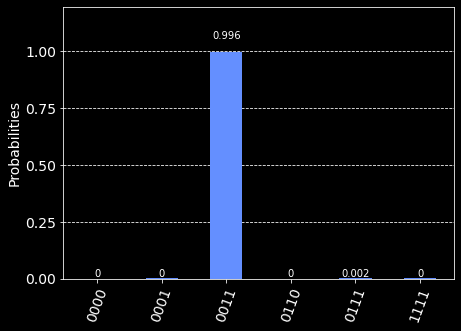

Input state: 0001
Output state:


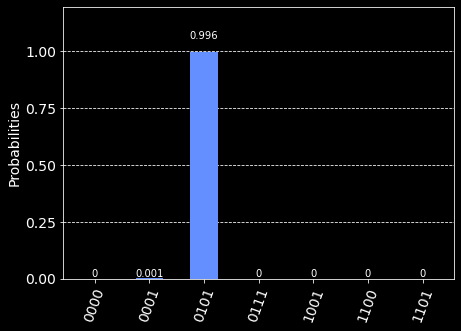

Input state: 0010
Output state:


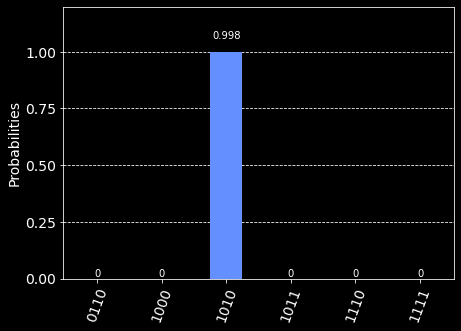

Input state: 0011
Output state:


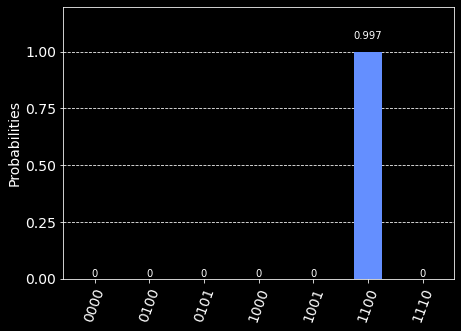

In [19]:
from qiskit.visualization import plot_histogram
from matplotlib import style
style.use('dark_background')

# Test the parameters by inputting each random state and observing the output
for i in range(4):
    print(f"Input state: {random_states[i]}")
    print(f"Output state:")
    qc_test = create_circuit(random_states[i], min_params)
    counts = simulate(qc_test)
    display(plot_histogram(counts))

## Part-2:
What happens if we input some other state?



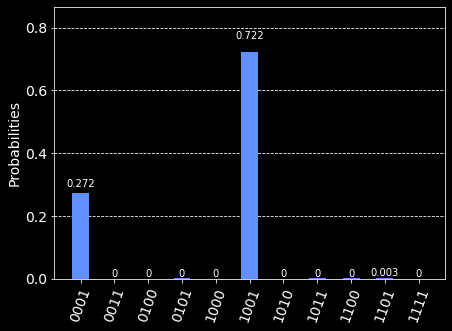

In [20]:
qc_test = create_circuit('1101', min_params)
counts = simulate(qc_test)
display(plot_histogram(counts))

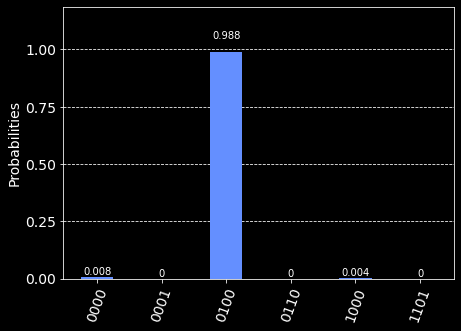

In [21]:
qc_test = create_circuit('1011', min_params)
counts = simulate(qc_test)
display(plot_histogram(counts))

### Result:
It gives a state which is not in the output set, but is within the Hilbert Space spanned by the 4-qubits. Hence, we can see that we have successfully mapped a state $|s \rangle$ to another state $|t \rangle$ in the same Hilbert Space via $|t\rangle=U~|s\rangle$. We can find out all the transformation pairs for the above circuit by just inputing each state in the $\mathcal{H}(\mathbb{C}^4)$ and observing the output, as follows:

In [22]:
for i in range(2**4):
    qc_test = create_circuit(f'{i:4b}', min_params)
    counts = simulate(qc_test)
    max_count_state = [k for k, v in counts.items() if v == max(counts.values())][0]
    print(f'|{i:04b}> --> |{max_count_state}>')

|0000> --> |0011>
|0001> --> |0101>
|0010> --> |1010>
|0011> --> |1100>
|0100> --> |0111>
|0101> --> |0001>
|0110> --> |1110>
|0111> --> |1000>
|1000> --> |1011>
|1001> --> |1101>
|1010> --> |0010>
|1011> --> |0100>
|1100> --> |1111>
|1101> --> |1001>
|1110> --> |0110>
|1111> --> |0000>


## References :
[1] Benedetti, M., Garcia-Pintos, D., Perdomo, O. et al. A generative modeling approach for benchmarking and training shallow quantum circuits. npj Quantum Inf 5, 45 (2019). https://doi.org/10.1038/s41534-019-0157-8
